### Use kernel conda_tensorflow2_p310

In [1]:
import os
import boto3
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow import feature_column
from sklearn.utils import resample
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

In [2]:
print(tf.__version__)

2.11.0


In [3]:
%run ./read_file.ipynb

:: loading settings :: url = jar:file:/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ec2-user/.ivy2/cache
The jars for the packages stored in: /home/ec2-user/.ivy2/jars
graphframes#graphframes added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-78ca78a5-a888-4797-a25b-a7701c908b49;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.2-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
:: resolution report :: resolve 148ms :: artifacts dl 6ms
	:: modules in use:
	graphframes#graphframes;0.8.2-spark3.2-s_2.12 from spark-packages in [default]
	org.slf4j#slf4j-api;1.7.16 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   2   |   0   |   0   |   0   ||   2   |   0   |
	-----------------------------

23/04/09 17:25:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/04/09 17:25:02 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [4]:
# https://stackoverflow.com/questions/68036975/valueerror-shape-must-be-at-least-rank-3-but-is-rank-2-for-node-biasadd
# config for rank error in lstm
tf.config.threading.set_inter_op_parallelism_threads(16)
pd.set_option('display.max_columns', None)
tf.keras.backend.set_image_data_format("channels_last")

In [5]:
# Set Config
embedding_dim = 64
max_length = 6
sequence_length = 6
max_features = 10000
padding_type = 'post'
trunc_type = 'post'
training_portion = 0.8

In [6]:
METRICS = [
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.BinaryCrossentropy(name='binary cross entropy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc'),
        keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [7]:
ds = spark.read.parquet(*["s3a://sapient-bucket-trusted/prod/graph/encoded/real/23Sep6/*"]).cache()

In [8]:
tot = ds.count()

In [9]:
ds.groupBy("mal_trace") \
    .count() \
    .withColumnRenamed('count', 'cnt_per_group') \
    .withColumn('perc_of_count_total', (col('cnt_per_group') / tot) * 100 ) \
    .sort("perc_of_count_total").show()

+---------+-------------+-------------------+
|mal_trace|cnt_per_group|perc_of_count_total|
+---------+-------------+-------------------+
|        1|       128364| 0.8923661690584941|
|        0|     14256314|  99.10763383094151|
+---------+-------------+-------------------+



In [10]:
def balance_dataframe(ds, ratio):
    # Calculate the number of malicious and non-malicious records
    malicious_count = ds.filter(col("mal_trace") == 1).count()
    non_malicious_count = ds.filter(col("mal_trace") == 0).count()

    target_non_malicious_count = malicious_count * ratio

    fraction_non_malicious = target_non_malicious_count / non_malicious_count
    
    # Sample the records based on the calculated fractions
    malicious_ds = ds.filter(col("mal_trace") == 1)
    non_malicious_ds = ds.filter(col("mal_trace") == 0).sample(fraction_non_malicious)

    # Combine the datasets
    balanced_ds = malicious_ds.union(non_malicious_ds)

    return balanced_ds

In [11]:
# Replace this with ratio of distribution, e.g. ratio of 2 non malicious records to 1 malicious record (1, 2, or 3)
ratio = 5

In [12]:
balanced_ds = balance_dataframe(ds, ratio)

In [13]:
balanced_ds.count()

768407

In [14]:
ds.unpersist()

DataFrame[Trace: bigint, mal_trace: int, event_sequence: array<string>]

In [15]:
balanced_ds.limit(5).toPandas()

,Trace,mal_trace,event_sequence
0,8589979742,1,[000100000000100000000000000000010000001000010...
1,8589990808,1,[010000000000100000000000000000010000001000010...
2,8589990928,1,[001000000000100000000000000000010000001000010...
3,8589991151,1,[001000000000100000000000000000010000001000010...
4,8589991652,1,[100000000000000000001000000000010000000100000...


In [16]:
ds_events = balanced_ds.select('event_sequence').rdd.flatMap(lambda x: x).collect()

In [17]:
ds_labels = balanced_ds.select('mal_trace').rdd.flatMap(lambda x: x).collect()

In [18]:
# Data conversion - https://towardsdatascience.com/multi-class-text-classification-with-lstm-using-tensorflow-2-0-d88627c10a35
tokenizer = tf.keras.preprocessing.text.Tokenizer()

In [19]:
tokenizer.fit_on_texts(ds_events)

In [20]:
# Get our training data word index
word_index = tokenizer.word_index
vocab_count = len(word_index)

In [21]:
# train test split data
train_set, validation_set, train_labels, validation_labels = train_test_split(ds_events, ds_labels,
                                                    stratify=ds_labels, 
                                                    test_size=0.2)

In [22]:
Counter(train_labels)

Counter({0: 512034, 1: 102691})

In [23]:
Counter(validation_labels)

Counter({0: 128009, 1: 25673})

In [24]:
train_sequences = tokenizer.texts_to_sequences(train_set)
train_padded = tf.keras.utils.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [25]:
validation_sequences = tokenizer.texts_to_sequences(validation_set)
validation_padded = tf.keras.utils.pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [26]:
validation_sequences[0]

[25, 2, 9, 6, 2, 14]

In [27]:
validation_padded[0]

array([25,  2,  9,  6,  2, 14], dtype=int32)

In [28]:
train_padded.shape

(614725, 6)

In [29]:
validation_padded.shape

(153682, 6)

In [30]:
train_ds = tf.reshape(train_padded, (len(train_padded),6,1))

In [31]:
validation_ds = tf.reshape(validation_padded, (len(validation_padded),6,1))

In [32]:
train_labels_ds = tf.ragged.constant(train_labels)
validation_labels_ds = tf.ragged.constant(validation_labels)

In [33]:
train_ds.shape

TensorShape([614725, 6, 1])

In [34]:
train_labels_ds.shape

TensorShape([614725])

In [35]:
validation_ds.shape

TensorShape([153682, 6, 1])

In [36]:
validation_labels_ds.shape

TensorShape([153682])

In [37]:
validation_ds[0]

<tf.Tensor: shape=(6, 1), dtype=int32, numpy=
array([[25],
       [ 2],
       [ 9],
       [ 6],
       [ 2],
       [14]], dtype=int32)>

In [38]:
def create_lstm():
    model = tf.keras.models.Sequential()
    model.add(layers.Embedding(vocab_count + 1, 16))
    model.add(keras.layers.LSTM(500, input_shape=(train_ds.shape[1], train_ds.shape[2]), return_sequences=True))
    model.add(keras.layers.LSTM(300, return_sequences=True))
    model.add(keras.layers.LSTM(200))
    model.add(keras.layers.Dense(train_ds.shape[2], activation='tanh'))
    model.compile(loss='binary_crossentropy', 
              optimizer='adam',
              metrics=METRICS)
    return model

In [39]:
model = create_lstm()

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          5024      
                                                                 
 lstm (LSTM)                 (None, None, 500)         1034000   
                                                                 
 lstm_1 (LSTM)               (None, None, 300)         961200    
                                                                 
 lstm_2 (LSTM)               (None, 200)               400800    
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 2,401,225
Trainable params: 2,401,225
Non-trainable params: 0
_________________________________________________________________


In [41]:
checkpoint_path = "saved_model/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

In [42]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [43]:
history = model.fit(
                x=train_ds,
                y=train_labels_ds,
                batch_size=128,
                epochs=11,
                verbose=0,
                validation_split=0.0,
                validation_data=(validation_ds, validation_labels_ds),
                shuffle=True,
                class_weight=None,
                sample_weight=None,
                initial_epoch=0,
                steps_per_epoch=None,
                validation_steps=None,
                validation_batch_size=None,
                validation_freq=1,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                callbacks=[cp_callback]
                )


Epoch 1: saving model to saved_model/cp.ckpt

Epoch 2: saving model to saved_model/cp.ckpt

Epoch 3: saving model to saved_model/cp.ckpt

Epoch 4: saving model to saved_model/cp.ckpt

Epoch 5: saving model to saved_model/cp.ckpt

Epoch 6: saving model to saved_model/cp.ckpt

Epoch 7: saving model to saved_model/cp.ckpt

Epoch 8: saving model to saved_model/cp.ckpt

Epoch 9: saving model to saved_model/cp.ckpt

Epoch 10: saving model to saved_model/cp.ckpt

Epoch 11: saving model to saved_model/cp.ckpt


In [44]:
def plot_graphs(history, metrics):
    fig, axs = plt.subplots(nrows = 2, ncols=3, figsize=(12, 6), layout="constrained")
    for ax, m in zip(axs.flat, metrics):
        ax.plot(history.history[m])
        ax.plot(history.history['val_'+ m])
        ax.set_title(f'{m}')
        # ax.xlabel("Epochs")
        # ax.ylabel(m)
        # ax.legend([m, 'val_'+ m])
        # ax.show()

In [45]:
metrics = ["accuracy", "loss", "prc", "recall", "auc", "precision"]

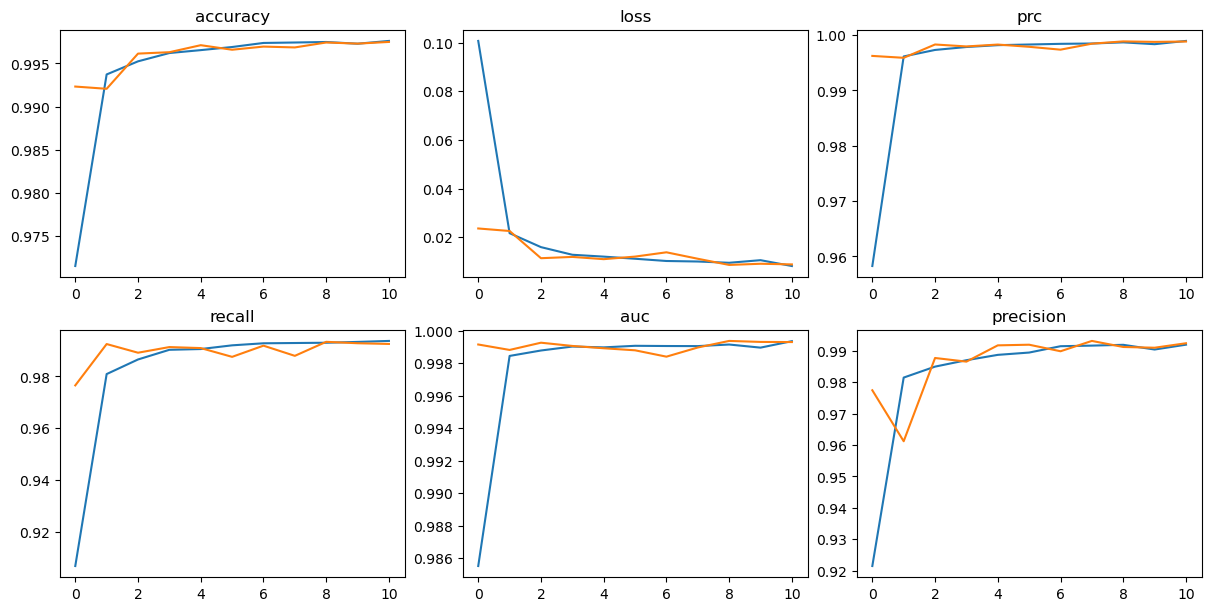

In [46]:
plot_graphs(history, metrics)

In [47]:
# Create a basic model instance
#model = create_lstm()
#model.load_weights(checkpoint_path)

In [48]:
# Re-evaluate the model
#loss, tp, fp, tn, fn, accuracy, precision, recall, auc, prc = model.evaluate(train_ds, train_labels_ds, verbose=1)

In [49]:
#print("Restored model, accuracy: {:5.2f}%".format(100 * accuracy))

In [50]:
#pred = model.predict(validation_ds)

In [51]:
#pred_class = np.argmax(pred, axis=-1)

In [52]:
#pred_class = list(pred_class)

In [53]:
#correct_len = len([i for i, j in zip(pred_class, validation_labels) if i == j])
#total_len = len(pred_class) 
#incorrect_len = total_len - correct_len

In [54]:
#print(f'From a total of {total_len} traces, we correctly predicted {correct_len} and incorrectly predicted {incorrect_len}')

In [55]:
# labels for the data - 

In [56]:
# if theyre predicted to be malicious, add trace ids to a list of values 

In [57]:
# trace, malicious_trace

In [58]:
# 

#### SHAP

In [59]:
#pip install shap


In [66]:
import numpy as np
import shap
import tensorflow as tf
from tensorflow.keras import layers

# Convert tensors to NumPy arrays and flatten to 2D
train_ds_np = train_ds.numpy().reshape(train_ds.shape[0], -1)
background = train_ds_np[:1000]

# Function to predict using the Keras model
def f(x):
    x_reshaped = x.reshape(-1, train_ds.shape[1], train_ds.shape[2])
    return model(x_reshaped).numpy()

# Initialize KernelExplainer
explainer = shap.KernelExplainer(f, background)

# Compute SHAP values
shap_values = explainer.shap_values(train_ds_np[:10], nsamples=1000)



Using 1000 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
print(shap_values)

[array([[-0.01766586, -0.07217286, -0.09383943, -0.07126316,  0.00441435,
        -0.01707211],
       [ 0.10586741, -0.03109048, -0.09231268, -0.07186057, -0.0742794 ,
        -0.00425267],
       [ 0.05004619, -0.08491061, -0.00601722, -0.04146668, -0.11404727,
        -0.00495384],
       [-0.06203349, -0.05542526, -0.04946806, -0.05670425, -0.03509804,
        -0.01005299],
       [-0.13176672,  0.03204296, -0.14413078, -0.04447203, -0.02935255,
        -0.01465628],
       [ 0.10408039, -0.08401157, -0.05290592, -0.03859016, -0.03112367,
        -0.05460027],
       [ 0.04214014,  0.42456437,  0.39342681,  0.12041751,  0.00234969,
         0.20067258],
       [-0.046969  ,  0.04186077, -0.08067575, -0.2283229 ,  0.08913103,
        -0.00690034],
       [-0.02131251,  0.04995694,  0.521536  ,  0.55888393,  0.09180735,
        -0.01662577],
       [-0.007234  ,  0.01042225, -0.08799624, -0.06575593, -0.05080251,
        -0.05153993]])]


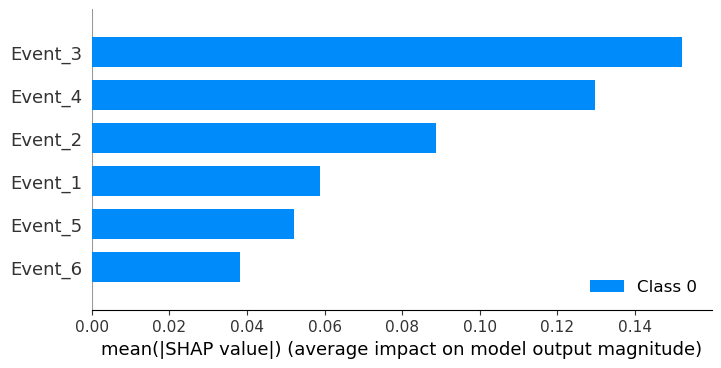

In [69]:
feature_names = ["Event_1", "Event_2", "Event_3", "Event_4", "Event_5", "Event_6"]
shap.summary_plot(shap_values, train_ds_np[:10], feature_names=feature_names)